In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/Downloads/Log In - AgInjuryNews (1).xlsx - Sheet1 (1) - Log In - AgInjuryNews (1).xlsx - Sheet1 (1).csv')

X = pd.DataFrame(dataset.iloc[:,:18].values)
Y = pd.DataFrame(dataset.iloc[:,18:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
X_train, X_train_val, Y_train, Y_train_val = train_test_split(X,Y,test_size=0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.reshape(2735,18,1)
X_test.reshape(684,18,1)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

features = pd.DataFrame(dataset.iloc[:,:18])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0      3   2   2  25   0   3  10   0   0   0   0   0   0   0   0   0   1   1
1      3   3   1  61   0   3  10   0   0   0   0   0   0   0   0   0   7   1
2      3   3   1  65   0   3  10   0   0   0   0   0   0   0   0   0   6   1
3      3   2   1  49   0   3  10   0   0   0   1   0   0   0   0   0   5   1
4      3   1   1  54   0   5   2   1   1   0   0   0   0   0   0   1   5   1
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3414   1   2   1  57   0   6   7   0   0   0   0   0   0   0   0   0   1   4
3415   1   1   1  24   0   3   7   0   0   0   0   0   0   0   0   0   1   4
3416   1   1   1  50   0   3  10   0   0   0   0   0   0   0   0   0   6   4
3417   1   2   1  58   0   3   9   0   0   0   0   0   0   0   0   0   6   4
3418   1   2   1   3   0   4  10   0   0   0   0   0   0   0   0   0   5   4

[3419 rows x 18 columns]
      0
0     0
1     1
2     1
3     0
4     1
..

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GRU, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [3]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=64, max_value=256, step=16)
  model.add(GRU(hp_units, return_sequences=True, input_shape=(18, 1)))
  model.add(Dropout(0.5))

  # Second GRU layer
  hp_units2 = hp.Int('units2', min_value=32, max_value=64, step=4)
  model.add(GRU(hp_units2, return_sequences=False))
  model.add(Dropout(0.5))

  # Dense layer with more units
  model.add(Dense(hp_units2, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4,1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [4]:
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape = (18,)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [5]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='gru_hyper',
                     project_name='gru_hyper')


Reloading Tuner from gru_hyper\gru_hyper\tuner0.json


In [6]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



In [7]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=1000, validation_split=0.2)


Epoch 1/1000


69/69 [==============================] - 5s 32ms/step - loss: 0.6650 - accuracy: 0.4776 - val_loss: 0.6704 - val_accuracy: 0.3876
Epoch 2/1000
69/69 [==============================] - 1s 21ms/step - loss: 0.6623 - accuracy: 0.4703 - val_loss: 0.6680 - val_accuracy: 0.4717
Epoch 3/1000
69/69 [==============================] - 1s 20ms/step - loss: 0.6577 - accuracy: 0.5151 - val_loss: 0.6685 - val_accuracy: 0.5649
Epoch 4/1000
69/69 [==============================] - 1s 22ms/step - loss: 0.6591 - accuracy: 0.4977 - val_loss: 0.6679 - val_accuracy: 0.4881
Epoch 5/1000
69/69 [==============================] - 2s 23ms/step - loss: 0.6597 - accuracy: 0.5101 - val_loss: 0.6676 - val_accuracy: 0.4826
Epoch 6/1000
69/69 [==============================] - 1s 21ms/step - loss: 0.6584 - accuracy: 0.5050 - val_loss: 0.6686 - val_accuracy: 0.5887
Epoch 7/1000
69/69 [==============================] - 2s 23ms/step - loss: 0.6585 - accuracy: 0.4822 - val_loss: 0.6679 - val_accuracy: 0.5

In [8]:
val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 955


In [9]:
# hypermodel = tuner.hypermodel.build(best_hps)
# hypermodel.fit(X_train, Y_train, epochs=, validation_split=0.2)

In [10]:
res = model.predict(X_test)
res.round()
actual = []
for num in res:
    if num>0.5:
        actual.append(1)
    else:
        actual.append(0)
from sklearn.metrics import classification_report
print(classification_report(Y_test,actual,digits=6))

22/22 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0   0.734982  0.815686  0.773234       255
           1   0.882793  0.825175  0.853012       429

    accuracy                       0.821637       684
   macro avg   0.808888  0.820431  0.813123       684
weighted avg   0.827688  0.821637  0.823270       684



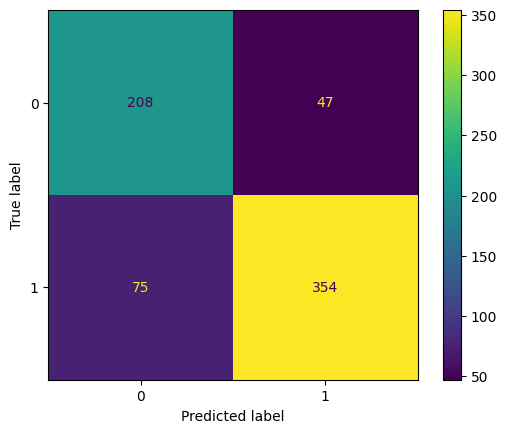

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, actual)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()